# This notebook prepares the dataset for NER
## We will try solving:
- Token classification
- Word Classification
- Statement Classification

## Following https://huggingface.co/course/chapter7/2?fw=pt

### This notebook splits the sessions with too statements
#### We also try to provide some "context" to the splitted statements

## Read dataset of labeled sessions

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

input_file = "./supervised_corpus.json"

In [18]:
df_labels = pd.read_json(input_file, orient='index').reset_index(drop = True)
print(f"Dataset contains {df_labels.shape[0]} elements")
df_labels.head(2)

Dataset contains 359 elements


,session,labels
0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution - 4
1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution - 4


In [19]:
from tqdm import tqdm
tqdm.pandas()

### Function to obtain statements

In [20]:
import re
special_token = "[STAT]"
def divide_statements(session, add_special_token = False):
    statements = re.split(r'(; |\|\|? |&& )', session+" ")
    # concatenate with separators
    statements = ["".join(statements[i:i+2]).strip() for i in range(0, len(statements)-1, 2)]
    if add_special_token:
        # Add separator
        statements = [f"{special_token} "+el for el in statements]
    return statements

#### First, truncate words that are longer than the 99th percentile

In [21]:
words = df_labels["session"].apply(lambda session: session.split(" "))
word_lengths = words.explode().apply(lambda word: len(word))
print(f"There are {word_lengths.shape[0]} words in the dataset")
word_lengths.head(2)

There are 17672 words in the dataset


0    3
0    2
Name: session, dtype: int64

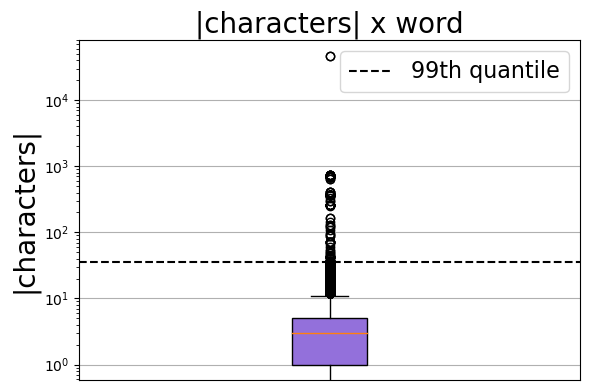

In [22]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, figsize =(6, 4))
fontsize = 20

bplot1 = axs.boxplot(word_lengths, positions = [0], patch_artist=True)
for patch in bplot1['boxes']:
    patch.set_facecolor("mediumpurple")
axs.set_title(f"|characters| x word", fontsize = fontsize)
axs.set_yscale("log")
axs.set_ylabel("|characters|", fontsize = fontsize)
axs.xaxis.set_ticks([])
line = axs.hlines(y = word_lengths.quantile(.99), 
      xmin = -.5, 
      xmax = .5,
      color = "black",
      linestyles='dashed'
    )
axs.legend([line], ["99th quantile"], fontsize = fontsize - 4, loc='upper right')
axs.grid()
plt.tight_layout()
plt.show()

#### Preprocessing to truncate words longer than threshold

In [23]:
threshold_characters = round(word_lengths.quantile(.99))
print(f"Chosen threshold is {threshold_characters}")

Chosen threshold is 35


In [24]:
import re
def truncate_long_words(max_length, session):
    return " ".join(map(lambda word: word[:max_length] if len(word) > max_length else word, session.split(" ")))
    
df_labels["truncated_session"] = df_labels["session"].apply(lambda session: truncate_long_words(threshold_characters, session))
df_labels.head(2)

,session,labels,truncated_session
0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution - 4,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;
1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution - 4,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;


### Split sessions into statements to visualize how the stats changed

In [25]:
df_labels["statements"] = df_labels["truncated_session"].progress_apply(lambda session: divide_statements(session))
df_labels["statements_special_token"] = df_labels["truncated_session"].progress_apply(lambda session: divide_statements(session, add_special_token = True))
df_labels.head(2)

100%|██████████| 359/359 [00:00<00:00, 77273.69it/s]


,session,labels,truncated_session,statements,statements_special_token
0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution - 4,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,"[scp -t /tmp/Muw3fuvA ;, cd /tmp &&, chmod +x Muw3fuvA &&, bash -c ./Muw3fuvA ;, ./Muw3fuvA ;]","[[STAT] scp -t /tmp/Muw3fuvA ;, [STAT] cd /tmp &&, [STAT] chmod +x Muw3fuvA &&, [STAT] bash -c ./Muw3fuvA ;, [STAT] ./Muw3fuvA ;]"
1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution - 4,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,"[scp -t /tmp/CaW87HUG ;, cd /tmp &&, chmod +x CaW87HUG &&, bash -c ./CaW87HUG ;, ./CaW87HUG ;]","[[STAT] scp -t /tmp/CaW87HUG ;, [STAT] cd /tmp &&, [STAT] chmod +x CaW87HUG &&, [STAT] bash -c ./CaW87HUG ;, [STAT] ./CaW87HUG ;]"


### Some stats on sessions' length
##### In terms of number of words:

In [26]:
n_words = df_labels["truncated_session"].apply(lambda session: len(session.split(" ")))
description_n_words = n_words.describe().rename("n_words")

##### In terms of number of statements

In [27]:
n_statements = df_labels["statements_special_token"].apply(lambda statements: len(statements))
description_n_statements = n_statements.describe().rename("n_statements")

#### In terms of number of characters

In [28]:
n_chars = df_labels["truncated_session"].apply(lambda session: len(session))
description_n_chars = n_chars.describe().rename("n_characters")

In [29]:
pd.concat([description_n_words, description_n_statements, description_n_chars], axis = 1)

,n_words,n_statements,n_characters
count,359.000000,359.000000,359.000000
mean,49.225627,13.832869,283.947075
std,59.234189,16.575708,350.671256
min,2.000000,1.000000,5.000000
25%,10.000000,2.500000,62.500000
50%,18.000000,5.000000,136.000000
75%,72.000000,19.000000,378.500000
max,224.000000,57.000000,1734.000000


### Plot features against each other

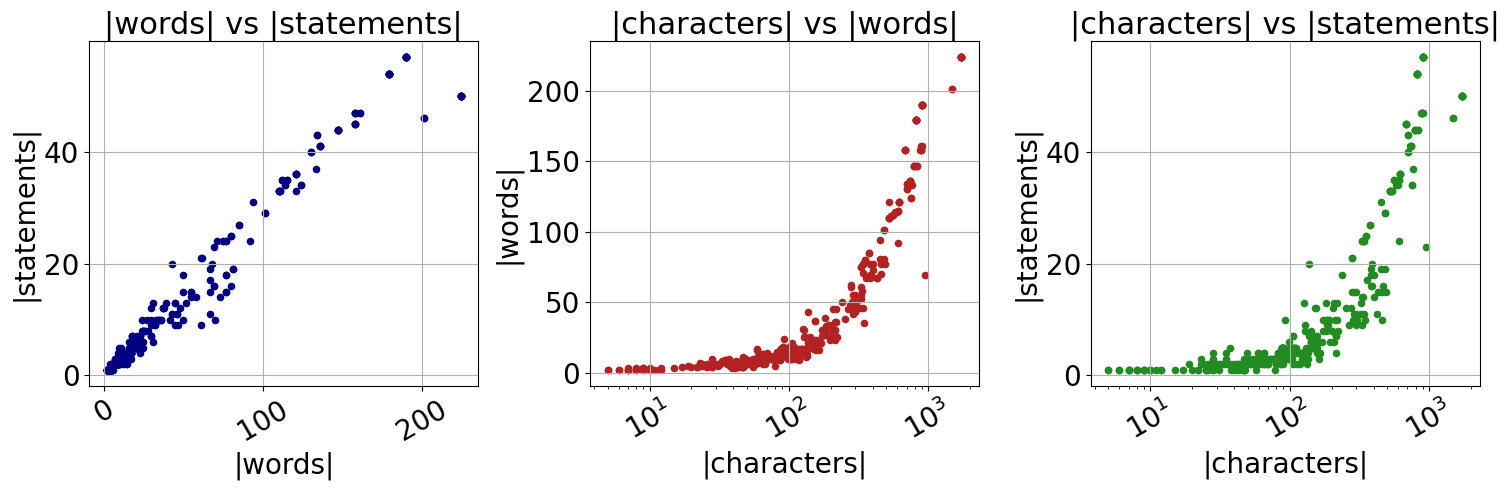

In [30]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1,3, figsize=(15,5))
fontsize = 20
axs[0].scatter(n_words, n_statements, s = 20, c = "navy")
axs[0].set_title(f"|words| vs |statements|", fontsize = fontsize + 2)
axs[0].set_xlabel("|words|", fontsize = fontsize)
axs[0].set_ylabel("|statements|", fontsize = fontsize)

axs[1].scatter(n_chars, n_words, s = 20, c = "firebrick")
axs[1].set_title(f"|characters| vs |words|", fontsize = fontsize + 2)
axs[1].set_xlabel("|characters|", fontsize = fontsize)
axs[1].set_ylabel("|words|", fontsize = fontsize)
axs[1].set_xscale("log")

axs[2].scatter(n_chars, n_statements, s = 20, c = "forestgreen")
axs[2].set_title(f"|characters| vs |statements|", fontsize = fontsize + 2)
axs[2].set_xlabel("|characters|", fontsize = fontsize)
axs[2].set_ylabel("|statements|", fontsize = fontsize)
axs[2].set_xscale("log")

for ax in axs:
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize, rotation = 30) 
    ax.grid()
plt.tight_layout()
plt.show()

##### Comment: Still have to work on the statements length, but at least for the words we are now ok 

#### How long each word is?

In [31]:
words = df_labels["truncated_session"].apply(lambda session: session.split(" "))
word_lengths = words.explode().apply(lambda word: len(word))
print(f"There are {word_lengths.shape[0]} words in the dataset")
word_lengths.head(2)

There are 17672 words in the dataset


0    3
0    2
Name: truncated_session, dtype: int64

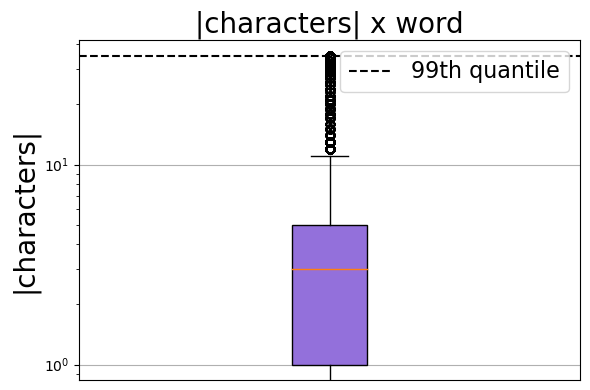

In [32]:
fig, axs = plt.subplots(1, figsize =(6, 4))
fontsize = 20

bplot1 = axs.boxplot(word_lengths, positions = [0], patch_artist=True)
for patch in bplot1['boxes']:
    patch.set_facecolor("mediumpurple")
axs.set_title(f"|characters| x word", fontsize = fontsize)
axs.set_yscale("log")
axs.set_ylabel("|characters|", fontsize = fontsize)
axs.xaxis.set_ticks([])
line = axs.hlines(y = threshold_characters, 
      xmin = -.5, 
      xmax = .5,
      color = "black",
      linestyles='dashed'
    )
axs.legend([line], ["99th quantile"], fontsize = fontsize - 4, loc='upper right')
axs.grid()
plt.tight_layout()
plt.show()

### Also, plot ECDF of |statements|

In [33]:
import numpy as np
cdf = n_statements.value_counts().sort_index().rename("cdf")
cdf_before = np.cumsum(cdf)/np.sum(cdf)
cdf_before.head(2)

1    0.119777
2    0.250696
Name: cdf, dtype: float64

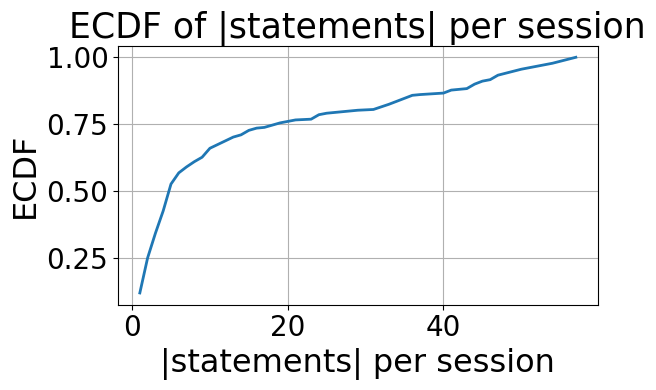

In [34]:
fig, axs = plt.subplots(1, figsize=(6,4))
fontsize = 20
axs.plot(cdf_before.reset_index()["index"], cdf_before.reset_index()["cdf"], linewidth = 2)
axs.set_xlabel('|statements| per session', fontsize = fontsize + 3)
axs.set_title(f'ECDF of |statements| per session', fontsize = fontsize + 5)
axs.set_ylabel('ECDF', fontsize = fontsize + 3)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.grid()
#axs.set_ylim(0,1.05)
plt.tight_layout()
plt.show()

Now it should not be the case of too long words (which creates too many tokens)

### Obtain statement_labels

In [35]:
def expand_labels(labels):
    labels = labels.split(" -- ")
    statement_labels = []
    prev_index = 0
    for label in labels:
        label, index = label.split(" - ")
        index = int(index)
        for it in range(index - prev_index + 1):
            statement_labels.append(label.strip())
        prev_index = (index + 1)
    return statement_labels
    
    
df_labels["statement_labels"] = df_labels["labels"].progress_apply(lambda label: expand_labels(label))
df_labels.head(2)

100%|██████████| 359/359 [00:00<00:00, 80776.52it/s]


,session,labels,truncated_session,statements,statements_special_token,statement_labels
0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution - 4,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,"[scp -t /tmp/Muw3fuvA ;, cd /tmp &&, chmod +x Muw3fuvA &&, bash -c ./Muw3fuvA ;, ./Muw3fuvA ;]","[[STAT] scp -t /tmp/Muw3fuvA ;, [STAT] cd /tmp &&, [STAT] chmod +x Muw3fuvA &&, [STAT] bash -c ./Muw3fuvA ;, [STAT] ./Muw3fuvA ;]","[Execution, Execution, Execution, Execution, Execution]"
1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution - 4,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,"[scp -t /tmp/CaW87HUG ;, cd /tmp &&, chmod +x CaW87HUG &&, bash -c ./CaW87HUG ;, ./CaW87HUG ;]","[[STAT] scp -t /tmp/CaW87HUG ;, [STAT] cd /tmp &&, [STAT] chmod +x CaW87HUG &&, [STAT] bash -c ./CaW87HUG ;, [STAT] ./CaW87HUG ;]","[Execution, Execution, Execution, Execution, Execution]"


### Make sure that operations were performed correctly

In [36]:
number_of_statements = df_labels["statements_special_token"].apply(lambda statements: len(statements))
number_of_labels = df_labels["statement_labels"].apply(lambda statements_labels: len(statements_labels))
assert number_of_statements.equals(number_of_labels), "Error: not all statements are labeled!"

In [37]:
import numpy as np
np.where((number_of_statements != number_of_labels))

(array([], dtype=int64),)

### Which is the set of labels?

In [38]:
class_names = list(df_labels["statement_labels"].explode().unique())
" - ".join(class_names)

'Execution - Discovery - Persistence - Harmless - Defense Evasion - Impact - Other'

### Export them. They will be useful later on

In [39]:
import os 
FOLDER = "./"
os.makedirs(FOLDER, exist_ok = True)

#### Export

In [40]:
class_names = ["{}\n".format(i) for i in class_names]
with open(f"./labels.txt", 'w+') as fp:
    fp.writelines(class_names)

## Before saving te dataset, make sure that we do not have too many statements for the same session

### Important that everybody can tokenize without truncation 
#### "Longest" (most token-consuming) tokenization so far it's Bert's

In [41]:
df_labels.head(2)

,session,labels,truncated_session,statements,statements_special_token,statement_labels
0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution - 4,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,"[scp -t /tmp/Muw3fuvA ;, cd /tmp &&, chmod +x Muw3fuvA &&, bash -c ./Muw3fuvA ;, ./Muw3fuvA ;]","[[STAT] scp -t /tmp/Muw3fuvA ;, [STAT] cd /tmp &&, [STAT] chmod +x Muw3fuvA &&, [STAT] bash -c ./Muw3fuvA ;, [STAT] ./Muw3fuvA ;]","[Execution, Execution, Execution, Execution, Execution]"
1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution - 4,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,"[scp -t /tmp/CaW87HUG ;, cd /tmp &&, chmod +x CaW87HUG &&, bash -c ./CaW87HUG ;, ./CaW87HUG ;]","[[STAT] scp -t /tmp/CaW87HUG ;, [STAT] cd /tmp &&, [STAT] chmod +x CaW87HUG &&, [STAT] bash -c ./CaW87HUG ;, [STAT] ./CaW87HUG ;]","[Execution, Execution, Execution, Execution, Execution]"


#### Obtain n_stats and n_words

In [42]:
n_words = df_labels.truncated_session.apply(lambda session: len(session.split(" ")))
n_stats = df_labels.statements_special_token.apply(lambda statement: len(statement))

In [43]:
threshold_n_stats = round(n_stats.mean()) 
context_n_stats = 4
print(f"Sessions will be splitted if > {threshold_n_stats} statements.\n{context_n_stats} statements will be added as a context for those cases")

Sessions will be splitted if > 14 statements.
4 statements will be added as a context for those cases


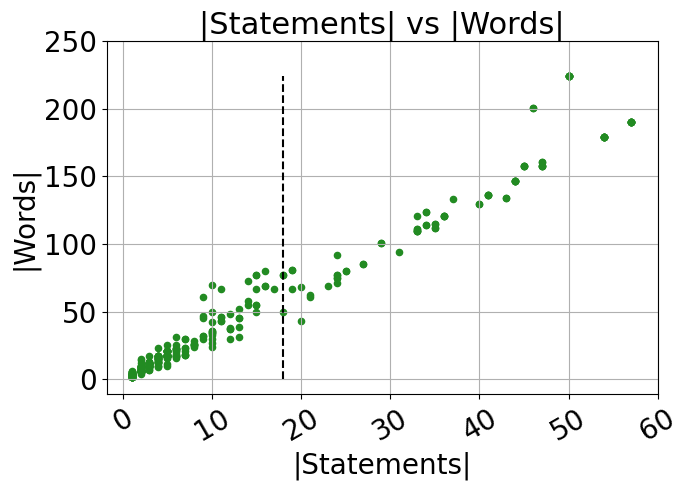

In [44]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, figsize=(7,5))
fontsize = 20
axs.scatter(n_stats, n_words, s = 20, c = "forestgreen")
axs.set_title(f"|Statements| vs |Words|", fontsize = fontsize + 2)
axs.set_xlabel("|Statements|", fontsize = fontsize)
axs.set_ylabel("|Words|", fontsize = fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 30) 
axs.vlines(x = threshold_n_stats + context_n_stats, ymin = 0, ymax = n_words.max(), linestyles = "dashed", color = "black", label = f"Threshold")

axs.xaxis.set_ticks(range(0, 61, 10))
axs.yaxis.set_ticks(range(0, 251, 50))

axs.grid()
plt.tight_layout()
plt.show()

In [45]:
df_labels.head(2)

,session,labels,truncated_session,statements,statements_special_token,statement_labels
0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution - 4,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,"[scp -t /tmp/Muw3fuvA ;, cd /tmp &&, chmod +x Muw3fuvA &&, bash -c ./Muw3fuvA ;, ./Muw3fuvA ;]","[[STAT] scp -t /tmp/Muw3fuvA ;, [STAT] cd /tmp &&, [STAT] chmod +x Muw3fuvA &&, [STAT] bash -c ./Muw3fuvA ;, [STAT] ./Muw3fuvA ;]","[Execution, Execution, Execution, Execution, Execution]"
1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution - 4,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,"[scp -t /tmp/CaW87HUG ;, cd /tmp &&, chmod +x CaW87HUG &&, bash -c ./CaW87HUG ;, ./CaW87HUG ;]","[[STAT] scp -t /tmp/CaW87HUG ;, [STAT] cd /tmp &&, [STAT] chmod +x CaW87HUG &&, [STAT] bash -c ./CaW87HUG ;, [STAT] ./CaW87HUG ;]","[Execution, Execution, Execution, Execution, Execution]"


### Divide sessions with n_statements > threshold in multiple parts
#### Before dividing, remember to also save a session_id (so that we can later map back to the original labels)

In [46]:
df_labels = df_labels.reset_index().rename({"index":"session_id"}, axis = 1)
df_labels.head(2)

,session_id,session,labels,truncated_session,statements,statements_special_token,statement_labels
0,0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution - 4,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,"[scp -t /tmp/Muw3fuvA ;, cd /tmp &&, chmod +x Muw3fuvA &&, bash -c ./Muw3fuvA ;, ./Muw3fuvA ;]","[[STAT] scp -t /tmp/Muw3fuvA ;, [STAT] cd /tmp &&, [STAT] chmod +x Muw3fuvA &&, [STAT] bash -c ./Muw3fuvA ;, [STAT] ./Muw3fuvA ;]","[Execution, Execution, Execution, Execution, Execution]"
1,1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution - 4,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,"[scp -t /tmp/CaW87HUG ;, cd /tmp &&, chmod +x CaW87HUG &&, bash -c ./CaW87HUG ;, ./CaW87HUG ;]","[[STAT] scp -t /tmp/CaW87HUG ;, [STAT] cd /tmp &&, [STAT] chmod +x CaW87HUG &&, [STAT] bash -c ./CaW87HUG ;, [STAT] ./CaW87HUG ;]","[Execution, Execution, Execution, Execution, Execution]"


In [47]:
import re
from tqdm import tqdm
tqdm.pandas()

def split_session(row, threshold, context):
    """Splits a session in a row if its length is greater than the threshold"""
    labels, statements, truncated_session, session_id = row.statement_labels, row.statements, row.truncated_session, row.session_id
    n_statements = len(statements)
    
    assert n_statements == len(labels), "Error!"
    if n_statements > (threshold + context):
        #print(f"Happening ({n_statements})!")
        splitted_sessions, splitted_labels, context_indeces = [], [], []
        start, prev_end = 0, 0
        end = threshold + context
        #print(f"\tAt the beginning, start : {start}\tend: {end}")
        while end <= n_statements:
            if end == n_statements: # means that the stride has reached exactly last partition of statements
                #print("\tExactly matching the statements length")
                splitted_sessions.append(" ".join(statements[start:]))
                splitted_labels.append(" -- ".join(labels[start:]))
                context_indeces.append([el for el in range(context)])
            else:
                #print(f"\tAppending from statement {start} to statement {end}")
                splitted_sessions.append(" ".join(statements[start : end]))
                splitted_labels.append(" -- ".join(labels[start : end]))
                if start == 0:
                    context_indeces.append([el for el in range(len(labels[start : end]) - 1, len(labels[start : end]) - 1 - context, -1)])
                else:
                    context_indeces.append([el for el in range(context)] + [el for el in range(len(labels[start : end]) - 1, len(labels[start : end]) - 1 - context, -1)])
            start += threshold - context
            prev_end = end
            end += threshold - context  
            #print(f"\tUpdated start : {start}\tend: {end}")
        #print(f"\nAt the end of the loop: {start}\tend: {end}")
        if prev_end != n_statements:
            #print(f"\nConcatenating remaining elements from index {start} to {n_statements}")                             
            splitted_sessions.append(" ".join(statements[start:]))
            splitted_labels.append(" -- ".join(labels[start:]))
            context_indeces.append([el for el in range(context)])
        
        split_data = pd.DataFrame({'sessions': splitted_sessions,
                                   'labels': splitted_labels, 
                                   'session_id': [session_id] * len(splitted_labels),
                                   'order_id': range(1, len(splitted_labels) + 1),
                                   'indexes_statements_context': context_indeces})
        return split_data
    else:
        split_data = pd.DataFrame({'sessions': [truncated_session],
                                  'labels':  [" -- ".join(labels)], 
                                  'session_id': [session_id],
                                  'order_id': [1],
                                  'indexes_statements_context': [[]]})
        return split_data    

# Apply the split_string function to each row of the DataFrame
split_data = df_labels.progress_apply(split_session, threshold = threshold_n_stats, context = context_n_stats, axis=1)
# Concatenate the resulting split data into a new DataFrame
new_df = pd.concat(split_data.tolist(), ignore_index=True)
new_df["sessions"] = new_df["sessions"].apply(lambda session: session.strip())
new_df["labels"] = new_df["labels"].apply(lambda session: session.strip())
print(f"After reshaping our sessions, we have {new_df.shape[0]} rows")
new_df.head(2)

100%|██████████| 359/359 [00:00<00:00, 2522.76it/s]

After reshaping our sessions, we have 597 rows


,sessions,labels,session_id,order_id,indexes_statements_context
0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution -- Execution -- Execution -- Execution -- Execution,0,1,[]
1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution -- Execution -- Execution -- Execution -- Execution,1,1,[]


In [48]:
df_labels["n_stat"] = df_labels["statement_labels"].apply(lambda el: len(el))
df_labels.head(2)

,session_id,session,labels,truncated_session,statements,statements_special_token,statement_labels,n_stat
0,0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution - 4,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,"[scp -t /tmp/Muw3fuvA ;, cd /tmp &&, chmod +x Muw3fuvA &&, bash -c ./Muw3fuvA ;, ./Muw3fuvA ;]","[[STAT] scp -t /tmp/Muw3fuvA ;, [STAT] cd /tmp &&, [STAT] chmod +x Muw3fuvA &&, [STAT] bash -c ./Muw3fuvA ;, [STAT] ./Muw3fuvA ;]","[Execution, Execution, Execution, Execution, Execution]",5
1,1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution - 4,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,"[scp -t /tmp/CaW87HUG ;, cd /tmp &&, chmod +x CaW87HUG &&, bash -c ./CaW87HUG ;, ./CaW87HUG ;]","[[STAT] scp -t /tmp/CaW87HUG ;, [STAT] cd /tmp &&, [STAT] chmod +x CaW87HUG &&, [STAT] bash -c ./CaW87HUG ;, [STAT] ./CaW87HUG ;]","[Execution, Execution, Execution, Execution, Execution]",5


### Convert indexes_statements_context to word_indexes (words that are context and that therefore will not be labeled)
#### Notice: valid only for token classification / word classification
##### For statement classification keep using indexes_statements_context

In [51]:
def statement2word(row):
    context_indexes = row.indexes_statements_context
    sessions = row.sessions
    statements = divide_statements(sessions)
    indexes_words_context = []
    current_index = 0
    for it, statement in enumerate(statements):
        if it in context_indexes:
            for word_id in range(len(statement.split(" "))):
                indexes_words_context.append(current_index + word_id)
        current_index += len(statement.split(" ")) # So that, while we progress with statements, words_id keep increasing
    return indexes_words_context

new_df["indexes_words_context"] = new_df.apply(lambda row: statement2word(row), axis = 1)
new_df.head(2)

,sessions,labels,session_id,order_id,indexes_statements_context,indexes_words_context
0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution -- Execution -- Execution -- Execution -- Execution,0,1,[],[]
1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution -- Execution -- Execution -- Execution -- Execution,1,1,[],[]


### Try recreating the original sessions and check if there is a match

In [52]:
def recreate_original_sessions(rows):
    rows.sort_values(by = "order_id", inplace = True)
    session_id = rows.session_id.iloc[0]
    sub_sessions = rows["sessions"]
    labels = rows["labels"]
    indexes_statements_context = rows["indexes_statements_context"].values
    indexes_words_context = rows["indexes_words_context"].values
    original_session = []
    original_labels = []
    for sub_session, label, statement_context, word_context in zip(sub_sessions, labels, indexes_statements_context, indexes_words_context): 
        words = sub_session.split(" ")
        label = label.split(" -- ")
        original_session.append(" ".join([words[it] for it in range(len(words)) if it not in word_context]))
        original_labels.append(" -- ".join([label[it] for it in range(len(label)) if it not in statement_context]))

    return pd.Series({'original_session': " ".join(original_session), "original_labels":" -- ".join(original_labels)})
    
grouped_df = new_df.groupby("session_id").progress_apply(recreate_original_sessions).reset_index()   
grouped_df.head(3)

100%|██████████| 359/359 [00:00<00:00, 1806.12it/s]


,session_id,original_session,original_labels
0,0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution -- Execution -- Execution -- Execution -- Execution
1,1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution -- Execution -- Execution -- Execution -- Execution
2,2,"cat /proc/cpuinfo | grep name | wc -l ; echo root:jBohy6hcgerO | chpasswd | bash ; cat /proc/cpuinfo | grep name | head -n 1 | awk {print $4,$5,$6,$7,$8,$9;} ; free -m | grep Mem | awk {print $2 ,$3, $4, $5, $6, $7} ; ls -lh $which ls ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ; uname -a ; lscpu | grep Model ; cd ~ && rm -rf .ssh && mkdir .ssh && echo ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun mdrfckr >> .ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~ ;",Discovery -- Discovery -- Discovery -- Persistence -- Persistence -- Persistence -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Persistence -- Persistence -- Persistence -- Persistence -- Persistence -- Persistence


In [53]:
sanity_check = df_labels[["session_id", "truncated_session", "statement_labels"]].merge(grouped_df, on = "session_id")
sanity_check["statement_labels"] = sanity_check["statement_labels"].apply(lambda label: " -- ".join(label))

In [54]:
assert sanity_check["truncated_session"].equals(sanity_check["original_session"]), "Error: we were not able to recreate some of the original sessions!"
assert sanity_check["statement_labels"].equals(sanity_check["original_labels"]), "Error: we were not able to recreate some of the original labels!"

In [55]:
sanity_check["truncated_session"].compare(sanity_check["original_session"])

,self,other


#### In how many pieces each session was divided?

In [56]:
n_splits = new_df.value_counts("session_id").value_counts().sort_index().reset_index().rename({"index":"|subsessions|", 0:"occurrences"}, axis = 1)
n_splits

,|subsessions|,occurrences
0,1,268
1,2,18
2,3,23
3,4,26
4,5,24


### Recreate statements

In [57]:
new_df["statements_special_token"] = new_df["sessions"].progress_apply(lambda session: divide_statements(session, add_special_token = True))
new_df.head(2)

100%|██████████| 597/597 [00:00<00:00, 59098.41it/s]


,sessions,labels,session_id,order_id,indexes_statements_context,indexes_words_context,statements_special_token
0,scp -t /tmp/Muw3fuvA ; cd /tmp && chmod +x Muw3fuvA && bash -c ./Muw3fuvA ; ./Muw3fuvA ;,Execution -- Execution -- Execution -- Execution -- Execution,0,1,[],[],"[[STAT] scp -t /tmp/Muw3fuvA ;, [STAT] cd /tmp &&, [STAT] chmod +x Muw3fuvA &&, [STAT] bash -c ./Muw3fuvA ;, [STAT] ./Muw3fuvA ;]"
1,scp -t /tmp/CaW87HUG ; cd /tmp && chmod +x CaW87HUG && bash -c ./CaW87HUG ; ./CaW87HUG ;,Execution -- Execution -- Execution -- Execution -- Execution,1,1,[],[],"[[STAT] scp -t /tmp/CaW87HUG ;, [STAT] cd /tmp &&, [STAT] chmod +x CaW87HUG &&, [STAT] bash -c ./CaW87HUG ;, [STAT] ./CaW87HUG ;]"


#### Obtain n_stats and n_words

In [58]:
n_words = new_df.sessions.apply(lambda session: len(session.split(" ")))
n_stats = new_df.statements_special_token.apply(lambda statement: len(statement))

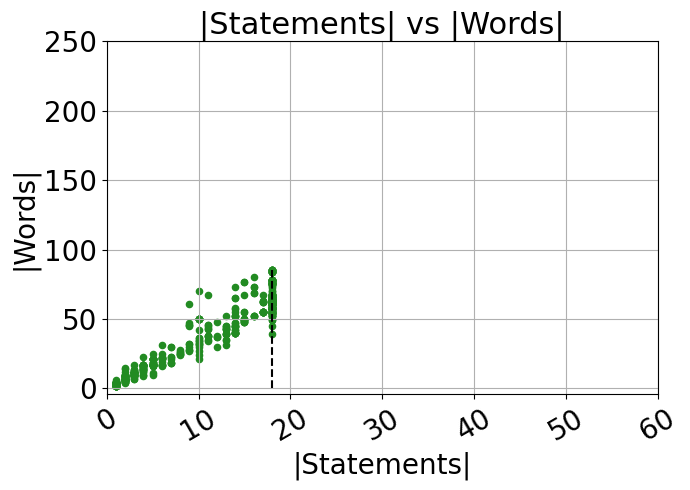

In [59]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, figsize=(7,5))
fontsize = 20
axs.scatter(n_stats, n_words, s = 20, c = "forestgreen")
axs.set_title(f"|Statements| vs |Words|", fontsize = fontsize + 2)
axs.set_xlabel("|Statements|", fontsize = fontsize)
axs.set_ylabel("|Words|", fontsize = fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 30) 
axs.vlines(x = threshold_n_stats + context_n_stats, ymin = 0, ymax = n_words.max(), linestyles = "dashed", color = "black", label = f"Threshold")

axs.xaxis.set_ticks(range(0, 61, 10))
axs.yaxis.set_ticks(range(0, 251, 50))

axs.grid()
plt.tight_layout()
plt.show()

### Also, plot ECDF of |statements|

In [60]:
import numpy as np
cdf = n_stats.value_counts().sort_index().rename("cdf")
cdf_after = np.cumsum(cdf)/np.sum(cdf)
cdf_after.head(2)

1    0.072027
2    0.150754
Name: cdf, dtype: float64

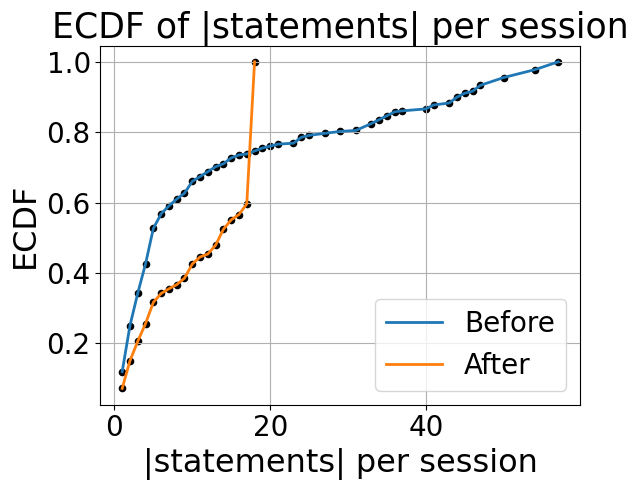

In [61]:
fig, axs = plt.subplots(1, figsize=(6,5))
fontsize = 20
axs.plot(cdf_before.reset_index()["index"], cdf_before.reset_index()["cdf"], linewidth = 2, label = "Before")
axs.scatter(cdf_before.reset_index()["index"], cdf_before.reset_index()["cdf"], c = "k", s = 20)

axs.plot(cdf_after.reset_index()["index"], cdf_after.reset_index()["cdf"], linewidth = 2, label = "After")
axs.scatter(cdf_after.reset_index()["index"], cdf_after.reset_index()["cdf"], c = "k", s = 20)

axs.set_xlabel('|statements| per session', fontsize = fontsize + 3)
axs.set_title(f'ECDF of |statements| per session', fontsize = fontsize + 5)
axs.set_ylabel('ECDF', fontsize = fontsize + 3)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.grid()
axs.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

### Make sure that operations were performed correctly

In [62]:
number_of_statements = new_df["statements_special_token"].apply(lambda statements: len(statements))
number_of_labels = new_df["labels"].apply(lambda statements_labels: len(statements_labels.split(" -- ")))
assert number_of_statements.equals(number_of_labels), "Error: not all statements are labeled!"

In [63]:
import numpy as np
np.where((number_of_statements != number_of_labels))

(array([], dtype=int64),)

## Now we can save the datasets

#### We will save:
- Dataset for word classification
- Dataset for statement classification
- Dataset for seq2seq

### Shuffle the dataset

In [64]:
new_df = new_df.sample(frac = 1, random_state = 29)

#### First, tokenize the session (split words)

In [65]:
new_df["tokenized_session"] = new_df["sessions"].apply(lambda session: session.split(" "))
new_df.head(2)

,sessions,labels,session_id,order_id,indexes_statements_context,indexes_words_context,statements_special_token,tokenized_session
294,"which awk ; echo 6z18a0jzqrz1 ; echo xo093rp7mik6 | awk {print toupper$0""te""} | grep -o .....$ ; which awk ; echo cd84gak9o2e8 ; echo zzidfdzkg5wr | awk {print toupper$0""f6""} | grep -o .....$ ;",Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery,135,1,[],[],"[[STAT] which awk ;, [STAT] echo 6z18a0jzqrz1 ;, [STAT] echo xo093rp7mik6 |, [STAT] awk {print toupper$0""te""} |, [STAT] grep -o .....$ ;, [STAT] which awk ;, [STAT] echo cd84gak9o2e8 ;, [STAT] echo zzidfdzkg5wr |, [STAT] awk {print toupper$0""f6""} |, [STAT] grep -o .....$ ;]","[which, awk, ;, echo, 6z18a0jzqrz1, ;, echo, xo093rp7mik6, |, awk, {print, toupper$0""te""}, |, grep, -o, .....$, ;, which, awk, ;, echo, cd84gak9o2e8, ;, echo, zzidfdzkg5wr, |, awk, {print, toupper$0""f6""}, |, grep, -o, .....$, ;]"
403,ps -x ; ps -x ; cat /proc/cpuinfo ;,Discovery -- Discovery -- Discovery,188,1,[],[],"[[STAT] ps -x ;, [STAT] ps -x ;, [STAT] cat /proc/cpuinfo ;]","[ps, -x, ;, ps, -x, ;, cat, /proc/cpuinfo, ;]"


#### Now, create labels for each token

In [66]:
def assign_labels2tokens(labels, statements):
    labels = labels.split(" -- ")
    tokens_labels = list()
    for label, statement in zip(labels, statements):
        for word in statement.split(" "):
            if word != "[STAT]":
                tokens_labels.append(label)
    return tokens_labels

In [67]:
new_df["tokens_labels"] = new_df.progress_apply(lambda row: assign_labels2tokens(row.labels, row.statements_special_token), axis = 1)
new_df.head(1)

100%|██████████| 597/597 [00:00<00:00, 31773.82it/s]


,sessions,labels,session_id,order_id,indexes_statements_context,indexes_words_context,statements_special_token,tokenized_session,tokens_labels
294,"which awk ; echo 6z18a0jzqrz1 ; echo xo093rp7mik6 | awk {print toupper$0""te""} | grep -o .....$ ; which awk ; echo cd84gak9o2e8 ; echo zzidfdzkg5wr | awk {print toupper$0""f6""} | grep -o .....$ ;",Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery,135,1,[],[],"[[STAT] which awk ;, [STAT] echo 6z18a0jzqrz1 ;, [STAT] echo xo093rp7mik6 |, [STAT] awk {print toupper$0""te""} |, [STAT] grep -o .....$ ;, [STAT] which awk ;, [STAT] echo cd84gak9o2e8 ;, [STAT] echo zzidfdzkg5wr |, [STAT] awk {print toupper$0""f6""} |, [STAT] grep -o .....$ ;]","[which, awk, ;, echo, 6z18a0jzqrz1, ;, echo, xo093rp7mik6, |, awk, {print, toupper$0""te""}, |, grep, -o, .....$, ;, which, awk, ;, echo, cd84gak9o2e8, ;, echo, zzidfdzkg5wr, |, awk, {print, toupper$0""f6""}, |, grep, -o, .....$, ;]","[Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery]"


### Make sure that operations were performed correctly

In [68]:
len_sessions = new_df["sessions"].apply(lambda session: len(session.split(" ")))
len_tokens_labels = new_df["tokens_labels"].apply(lambda tokens_labels: len(tokens_labels))
assert len_sessions.equals(len_tokens_labels), "Error: not all tokens are labeled!"

#### Decomment to compare columns

In [69]:
len_sessions.compare(len_tokens_labels)

,self,other


### Export for token/word classification

In [70]:
new_df[['tokenized_session', "tokens_labels", "session_id", "order_id", "indexes_statements_context", "indexes_words_context"]].to_csv(f"./token_classification.csv", index=False)

### Now export the one for statement classification

In [71]:
new_df["tokenized_statements"] = new_df["statements_special_token"].progress_apply(lambda statements: " ".join(statements).split(" "))
new_df["statement_labels"] = new_df["labels"].progress_apply(lambda labels: labels.split(" -- "))
new_df.head(1)

100%|██████████| 597/597 [00:00<00:00, 434495.83it/s]


,sessions,labels,session_id,order_id,indexes_statements_context,indexes_words_context,statements_special_token,tokenized_session,tokens_labels,tokenized_statements,statement_labels
294,"which awk ; echo 6z18a0jzqrz1 ; echo xo093rp7mik6 | awk {print toupper$0""te""} | grep -o .....$ ; which awk ; echo cd84gak9o2e8 ; echo zzidfdzkg5wr | awk {print toupper$0""f6""} | grep -o .....$ ;",Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery,135,1,[],[],"[[STAT] which awk ;, [STAT] echo 6z18a0jzqrz1 ;, [STAT] echo xo093rp7mik6 |, [STAT] awk {print toupper$0""te""} |, [STAT] grep -o .....$ ;, [STAT] which awk ;, [STAT] echo cd84gak9o2e8 ;, [STAT] echo zzidfdzkg5wr |, [STAT] awk {print toupper$0""f6""} |, [STAT] grep -o .....$ ;]","[which, awk, ;, echo, 6z18a0jzqrz1, ;, echo, xo093rp7mik6, |, awk, {print, toupper$0""te""}, |, grep, -o, .....$, ;, which, awk, ;, echo, cd84gak9o2e8, ;, echo, zzidfdzkg5wr, |, awk, {print, toupper$0""f6""}, |, grep, -o, .....$, ;]","[Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery]","[[STAT], which, awk, ;, [STAT], echo, 6z18a0jzqrz1, ;, [STAT], echo, xo093rp7mik6, |, [STAT], awk, {print, toupper$0""te""}, |, [STAT], grep, -o, .....$, ;, [STAT], which, awk, ;, [STAT], echo, cd84gak9o2e8, ;, [STAT], echo, zzidfdzkg5wr, |, [STAT], awk, {print, toupper$0""f6""}, |, [STAT], grep, -o, .....$, ;]","[Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery]"


In [72]:
new_df[['tokenized_statements', "statement_labels", "session_id", "order_id", "indexes_statements_context", "indexes_words_context"]].to_csv(f"./statement_classification.csv", index=False)

### Eventually, dataset for seq2seq

In [73]:
def remove_repetitions(list_elements):
    list_elements = list_elements.split(" -- ")
    prev_el = list_elements[0]
    non_repeated_list = [str(prev_el)]
    for el in list_elements[1:]:
        if prev_el != el:
            non_repeated_list.append(str(el))
            prev_el = el
    return " - ".join(non_repeated_list)

In [74]:
new_df["non_repeated_labels"] = new_df.labels.apply(lambda labels: remove_repetitions(labels))
new_df.head(1)

,sessions,labels,session_id,order_id,indexes_statements_context,indexes_words_context,statements_special_token,tokenized_session,tokens_labels,tokenized_statements,statement_labels,non_repeated_labels
294,"which awk ; echo 6z18a0jzqrz1 ; echo xo093rp7mik6 | awk {print toupper$0""te""} | grep -o .....$ ; which awk ; echo cd84gak9o2e8 ; echo zzidfdzkg5wr | awk {print toupper$0""f6""} | grep -o .....$ ;",Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery,135,1,[],[],"[[STAT] which awk ;, [STAT] echo 6z18a0jzqrz1 ;, [STAT] echo xo093rp7mik6 |, [STAT] awk {print toupper$0""te""} |, [STAT] grep -o .....$ ;, [STAT] which awk ;, [STAT] echo cd84gak9o2e8 ;, [STAT] echo zzidfdzkg5wr |, [STAT] awk {print toupper$0""f6""} |, [STAT] grep -o .....$ ;]","[which, awk, ;, echo, 6z18a0jzqrz1, ;, echo, xo093rp7mik6, |, awk, {print, toupper$0""te""}, |, grep, -o, .....$, ;, which, awk, ;, echo, cd84gak9o2e8, ;, echo, zzidfdzkg5wr, |, awk, {print, toupper$0""f6""}, |, grep, -o, .....$, ;]","[Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery]","[[STAT], which, awk, ;, [STAT], echo, 6z18a0jzqrz1, ;, [STAT], echo, xo093rp7mik6, |, [STAT], awk, {print, toupper$0""te""}, |, [STAT], grep, -o, .....$, ;, [STAT], which, awk, ;, [STAT], echo, cd84gak9o2e8, ;, [STAT], echo, zzidfdzkg5wr, |, [STAT], awk, {print, toupper$0""f6""}, |, [STAT], grep, -o, .....$, ;]","[Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery, Discovery]",Discovery


In [75]:
new_df[['sessions', "non_repeated_labels", 'session_id', 'order_id', "indexes_statements_context", "indexes_words_context"]].to_csv(f"./seq2seq.csv", index=False)

# To conclude, how many labels per classes?

In [76]:
tokens_per_label = new_df["tokens_labels"].explode().value_counts()
statements_per_label = new_df["statement_labels"].explode().value_counts()
non_repeated_labels = new_df["non_repeated_labels"].apply(lambda label: label.split(" - "))
labels_occurrences = non_repeated_labels.explode().value_counts()
pd.concat([tokens_per_label, statements_per_label, labels_occurrences], axis = 1).rename({"tokens_labels":"|tokens| x label", "statement_labels":"|statements| x label", "non_repeated_labels":"|occurrences|"}, axis = 1)

,|tokens| x label,|statements| x label,|occurrences|
Discovery,14489,4255,461
Execution,5740,1475,285
Persistence,2344,644,197
Defense Evasion,674,147,112
Harmless,540,147,77
Impact,508,134,36
Other,285,68,21
